In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
class DataLoder:
    def __init__(self, fdir, dt=0.01, fs=2000):
        self.fdir = fdir
        self.N  = None
        self.dt = dt
        self.fs = fs
        
        os.system("cat %s/result.txt"%(fdir))
        self._read_spike_data()
        self._read_check_data()
        self._read_single_data()
        
    def _read_single_data(self):
        keys = ["v", "h", "i", "n"]
        self.single = dict()
        for k in keys:
            with open(os.path.join(self.fdir, "./single_%s.txt"%(k)), "r") as fid:
                self.single[k] = [float(x) for x in fid.readline().split(",")[:-1]]
        self.single['t'] = np.arange(len(self.single["v"])) * self.dt / 1000 
        
    def _read_check_data(self):
        keys = ["v", "syn_e", "syn_i", "syn_ext"]
        self.data = dict()
        for k in keys:
            with open(os.path.join(self.fdir, "check_%s.dat"%(k)), "rb") as fid:
                self.data[k] = np.fromfile(fid, dtype=np.float32).reshape([-1, self.N])
        self.data["t"] = np.arange(self.data["v"].shape[0]) / self.fs
    
    def _read_spike_data(self):
        with open(os.path.join(self.fdir,"./spike_info.txt"), "r") as fid:
            self.num_spk = np.array([int(i) for i in fid.readline().split(",")[:-1]])
        self.N = len(self.num_spk)
        
        self.step_spk = []
        with open(os.path.join(self.fdir, "./spike.dat"), "rb") as fid:
            tmp = np.fromfile(fid, dtype=np.int32)
            n0 = 0
            for n in range(self.N):
                self.step_spk.append(tmp[n0:n0+self.num_spk[n]])
                n0 += self.num_spk[n]
                
                
def get_firing_info(obj, n_samples=200, mode="random"):
    tmax = obj.data["t"][-1]
    ne = int(0.8 * obj.N)
    ns = [[0, ne], [ne, obj.N]]
    frs, cvs = [], []
    for n_range in ns:
        if mode == "random":
            ind = np.random.randint(n_range[0], n_range[1], n_samples)
        elif mode == "full":
            ind = np.arange(n_range[0], n_range[1])
        else:
            print("Wrong mode selected")
            break

        fr, cv = [], []
        for i in ind:
            n_spk = np.array(obj.step_spk[i])
            fr.append(len(n_spk) / tmax)
            if len(n_spk) < 3:
                continue
            itv = n_spk[1:] - n_spk[:-1]
            mu = np.average(itv)
            s  = np.std(itv)
            cv.append(s/mu)
            
        frs.append(np.average(fr))
        cvs.append(np.average(cv))
    return frs, cvs


def plot_cond(x, y, cond, *args, **kwargs):
    return plt.plot(x[cond], y[cond], *args, **kwargs)


def get_corr(v, fs=2000):
    l = len(v)
    x = np.arange(-l, l-1) / fs
    y = v - np.average(v)
    c = np.correlate(y, y, mode='full')
    c = c / c[l]
    
    return c, x


class DrawSummary:
    def __init__(self, obj, tlim=None):
        self.tlim = tlim
        self.obj = obj
        self.draw_all()
        
    def draw_all(self):
        self.draw_single_summary()
        self.draw_raster()
        self.draw_two_neuron()
        self.draw_lfp()
        # self.draw_ac()
    
    def draw_single_summary(self):
        plt.figure(dpi=120, figsize=(6,2.5))
        plt.plot(self.obj.single["t"], self.obj.single["v"], c='k', label="v")
        plt.xlabel("Time (ms)", fontsize=14)
        plt.ylabel(r"$v_i (mV)$", fontsize=14)
        plt.twinx()
        plt.plot(self.obj.single["t"], self.obj.single["h"], c='g', label="h")
        plt.plot(self.obj.single["t"], self.obj.single["n"], c='r', label="n")
        plt.legend(loc='upper right')
        plt.ylabel("Ion concentration", fontsize=12)
        plt.title(obj.fdir, fontsize=14)
        plt.xlim(self.tlim)
        self.save_figure("fig_single.png")
        plt.show()
        
    def draw_raster(self, num_ratio=0.5):
        N = self.obj.N
        ne, ni = int(0.8 * N), int(0.2 * N)
    
        # inds = [*np.random.randint(0, ne, int(num_ratio * ne)),
        #        *np.random.randint(0, ni, int(num_ratio * ni)) + ne]
        inds = np.arange(0, self.obj.N)
        
        # cs = [*['r' for i in range(int(num_ratio * ne))],
        #       *['b' for i in range(int(num_ratio * ni))]]
        cs = [*['r' for i in range(int(ne))],
              *['b' for i in range(int(ni))]]
        
        plt.figure(dpi=120, figsize=(6,4))
        for n in range(len(inds)):
            nid = inds[n]
            spk = self.obj.step_spk[nid]
            plt.plot(np.array(spk) * self.obj.dt/1000, np.ones_like(spk) * n, cs[n]+'.', ms=1)

        plt.xlim(self.tlim)
        plt.xlabel("Time (s)", fontsize=14)
        plt.ylabel("ID", fontsize=14)
        plt.title(obj.fdir, fontsize=14)
        
        frs, cvs = get_firing_info(self.obj)
        plt.title("%s\n"%(obj.fdir)+r"$FR = %7.2f, %7.2f Hz, CV_{ISI} = %5.2f, %5.2f$"%(frs[0], frs[1], cvs[0], cvs[1]), fontsize=15)
        
        self.save_figure("fig_spk.png")
        plt.show()
        
        
    def draw_two_neuron(self):
        ind = np.random.randint(0, self.obj.N, 2)
        plt.figure(dpi=120, figsize=(6, 2))
        plt.plot(self.obj.data["t"], obj.data["v"][:,ind[0]], 'k', label="#%d"%(ind[0]), lw=1)
        plt.plot(self.obj.data["t"], obj.data["v"][:,ind[1]], 'r', label="#%d"%(ind[1]), lw=1)
        plt.xlabel("Time (s)", fontsize=14)
        plt.ylabel(r"$v_i$", fontsize=14)
        plt.xlim(self.tlim)
        plt.title(obj.fdir, fontsize=14)
        plt.legend(fontsize=13, loc="upper right")
        self.save_figure("fig_twosample.png")
        plt.show()
        
    def draw_lfp(self):
        ne = int(self.obj.N * 0.8)
        ve = np.average(self.obj.data["v"][:,:ne], axis=1)
        vi = np.average(self.obj.data["v"][:,ne:], axis=1)
        
        plt.figure(dpi=120, figsize=(6, 2))
        t = self.obj.data["t"] 
        cond = (t >= self.tlim[0]) & (t <= self.tlim[1])
        plot_cond(t, ve, cond, 'r', lw=1, label=r"$V_E$")
        plot_cond(t, vi, cond, 'b', lw=1, label=r"$V_I$")
        plt.title(obj.fdir, fontsize=14)
        
        plt.xlabel("Time (s)", fontsize=14)
        plt.ylabel(r"$v_i$", fontsize=14)
        plt.xlim(self.tlim)
        plt.legend(fontsize=13, loc="upper right")
        self.save_figure("fig_lfp.png")
        plt.show()
        
    def draw_ac(self, tau_lim=(-1, 1)):
        N = self.obj.N
        ne = int(0.8 * N)
        ve = np.average(obj.data["v"][:,:ne], axis=1)
        vi = np.average(obj.data["v"][:,ne:], axis=1)
        corr_e, x = get_corr(ve)
        corr_i, x = get_corr(vi)
        
        plt.figure(dpi=120, figsize=(4, 3))
        plt.plot(x, corr_e, c='r', lw=1.5, label=r"$V_E$")
        plt.plot(x, corr_i, c='b', lw=1.5, label=r"$V_I$")
        plt.xlim(tau_lim)
        plt.xlabel(r"$\tau (s)$", fontsize=14)
        plt.ylabel(r"AC($\tau$)", fontsize=14)
        plt.legend(loc="upper right", fontsize=13)
        plt.title(obj.fdir, fontsize=15)
        plt.tight_layout()
        plt.savefig(os.path.join(obj.fdir, "fig_autocorrelation.png"), facecolor='w')
        plt.show()
    
    def save_figure(self, fname):
        plt.tight_layout()
        plt.savefig(os.path.join(self.obj.fdir, fname), dpi=150, facecolor='w')

chi/frs_m/frs_s/cv_isi
0.872135,0.963750,0.842206,0.670899,
0.871608,1.030000,0.839107,0.652210,
cij
0.016442,0.013376,
0.000000,0.030246,


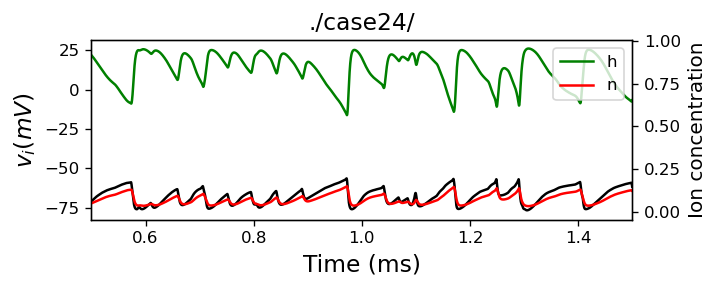

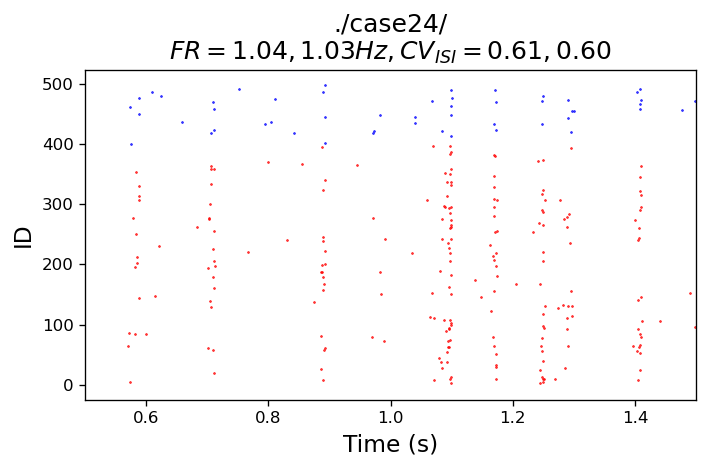

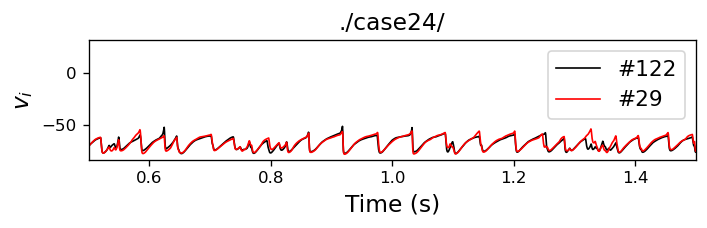

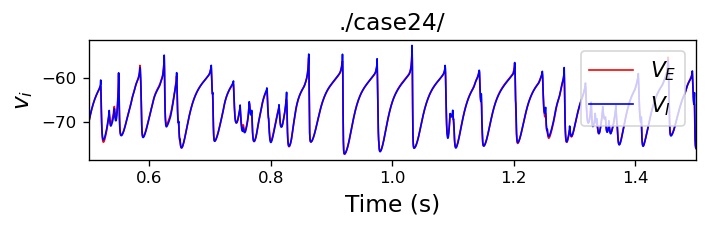

In [36]:
# obj = DataLoder("./case9_dec_e_dec_i///")
obj = DataLoder("./case24/", dt=0.01)
# visu = DrawSummary(obj, [0., 0.05])
visu = DrawSummary(obj, [0.5, 1.5])

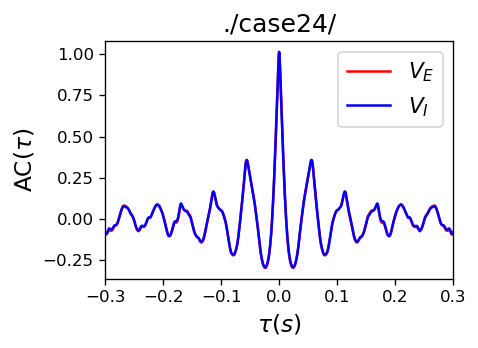

In [37]:
visu.draw_ac(tau_lim=(-0.3, 0.3))

## Test

In [7]:
obj = DataLoder("./test_dt=0.05/", dt=0.05)

cat: ./test_dt=0.05//result.txt: No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: './test_dt=0.05/./spike_info.txt'

In [29]:
obj.data["v"].shape

(4000, 500)

In [27]:
800 / 2000

0.4

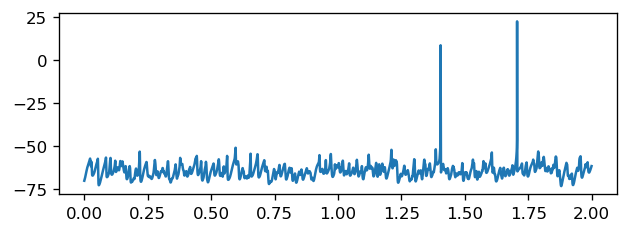

In [30]:
plt.figure(dpi=120, figsize=(6, 2))
plt.plot(obj.data["t"], obj.data["v"][:,0])
plt.show()

## Test lfp

chi/frs_m/frs_s/cv_isi
0.149993,18.592500,0.660639,0.131732,
0.170604,18.740000,0.729657,0.133289,
cij
0.047725,0.042645,
0.000000,0.061941,


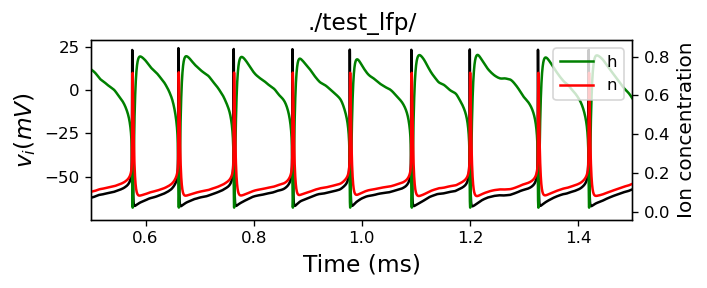

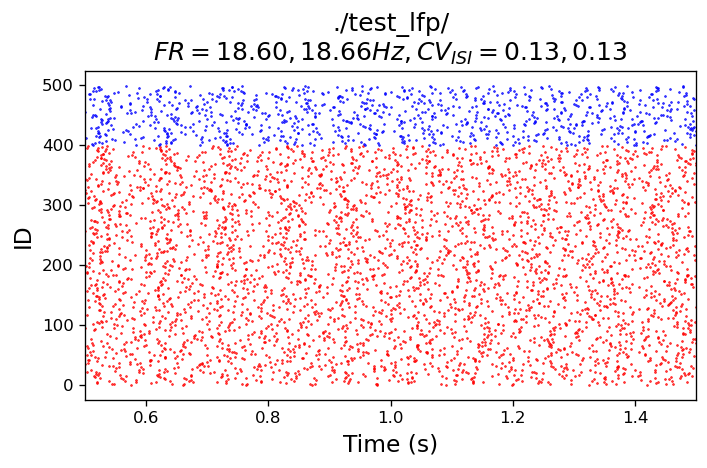

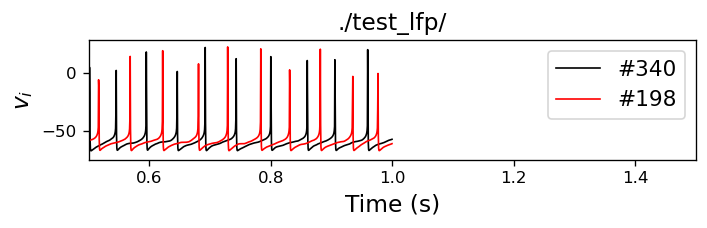

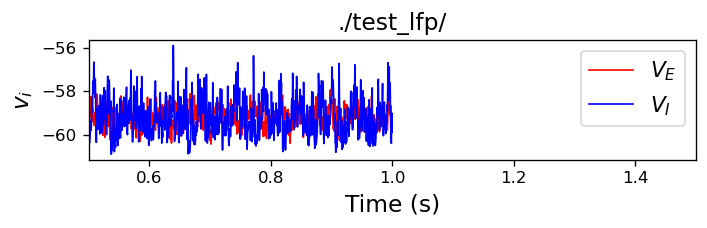

In [19]:
# obj = DataLoder("./case9_dec_e_dec_i///")
obj = DataLoder("./test_lfp/", dt=0.01)
# visu = DrawSummary(obj, [0., 0.05])
visu = DrawSummary(obj, [0.5, 1.5])

In [20]:
with open("./test_lfp/vlfp.dat", "rb") as fid:
    data = np.fromfile(fid, dtype=np.float32)
num = len(data)//2
ve = data[:num]
vi = data[num:]
t = np.arange(num) / 2000
# t = np.arange(1000) * 

In [21]:
obj.data["v"].shape

(2000, 500)

In [25]:
ve2 = np.average(obj.data["v"][:,:400], axis=1)

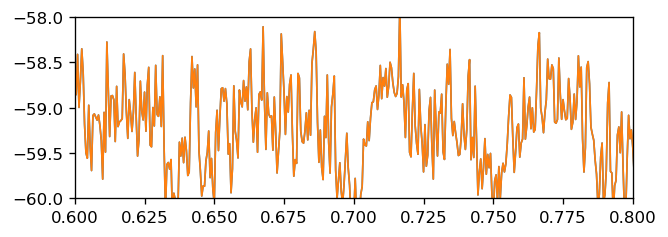

In [29]:
plt.figure(dpi=120, figsize=(6, 2))
plt.plot(t, ve, lw=1)
plt.plot(t, ve2, lw=1)
plt.xlim([0.6, 0.8])
plt.ylim([-60, -58])
plt.show()

## Track param change

In [115]:
import os
def read_info(fdir):
    info = {}
    info["fdir"] = fdir
    with open(os.path.join(fdir, "info.txt"), "r") as fp:
        line = fp.readline()
        while line:
            tmp = line[:-1].split(":")
            key = tmp[0]
            val = float(tmp[1])
            line = fp.readline()
            info[key] = val    
    return info

In [116]:
fdirs = [f for f in os.listdir() if "case" in f and "x" not in f]

flag = True
prev_info = {}
for f in fdirs:
    info = read_info(f)
    if flag:
        flag = False
        prev_info = info
        # print(info)
        for k in info.keys():
            print(f"{k}: {info[k]}")
        # print(f)
        continue
    print("\n%s->%s"%(prev_info["fdir"], f))
    
    # print("
    for k in info.keys():
        if "fdir" in k:
            continue
        d = info[k] - prev_info[k]
        if d > 1e-10:
            if d > 0:
                s = "+"
            elif d < 0:
                s = "-"
            else:
                print("ERRRRR")
                
            print(f"{k} changed: {prev_info[k]:5f}->{info[k]:5f}, d={s}{d:5f}")
    prev_info = info

fdir: case1
N: 2000.0
dt: 0.01
n_lag: 0.0
mean_deg_e2e: 320.0
mean_deg_e2i: 80.0
mean_deg_i2e: 640.0
mean_deg_i2i: 160.0
delay_e2e: 0.0
delay_e2i: 0.0
delay_i2e: 0.0
delay_i2i: 0.0
g_e2e: 0.001
g_e2i: 0.001
g_i2e: 0.2
g_i2i: 0.2
nu_ext: 8000.0
g_ext: 0.0005

case1->case6
n_lag changed: 0.000000->100.000000, d=+100.000000
delay_e2e changed: 0.000000->100.000000, d=+100.000000
delay_e2i changed: 0.000000->100.000000, d=+100.000000
delay_i2e changed: 0.000000->100.000000, d=+100.000000
delay_i2i changed: 0.000000->100.000000, d=+100.000000
g_e2e changed: 0.001000->0.050000, d=+0.049000
g_e2i changed: 0.001000->0.050000, d=+0.049000

case6->case5
g_e2e changed: 0.050000->0.100000, d=+0.050000
g_e2i changed: 0.050000->0.100000, d=+0.050000
g_i2e changed: 0.100000->0.200000, d=+0.100000
g_i2i changed: 0.100000->0.200000, d=+0.100000

case5->case2

case2->case3
g_e2e changed: 0.020000->0.100000, d=+0.080000
g_e2i changed: 0.020000->0.100000, d=+0.080000

case3->case4
g_i2e changed: 0.200000->

In [58]:
line

'N:2000\n'

In [ ]:
# 

## 

In [50]:
frs, cvs = get_firing_info(obj, mode="full")

In [51]:
print(frs, cvs)

[5.576826826826826, 5.7757757757757755] [0.764824672705161, 0.7747488515587456]


In [23]:
def get_chi(vs):
    V = np.average(vs, axis=1)
    sV = np.var(V)
    svi = np.var(vs, axis=0)
    # print("var tot: %f, var indiv: %f"%(sV, svi * vs.shape[1]))
    # print(np.average(svi))
    return np.sqrt(sV / np.average(svi))


In [27]:
obj.data["v"].shape

(1000, 2000)

In [29]:
c = get_chi(obj.data["v"][:,:1600])

In [34]:
np.average(obj.num_spk[:1600]), np.average(obj.num_spk[1600:])

(2.785625, 2.885)

In [36]:
with open("./case3/spike_info.txt", "r") as fid:
    data = [int(x) for x in fid.readline().split(",")[:-1]]

In [38]:
np.average(data[:1600])

2.785625

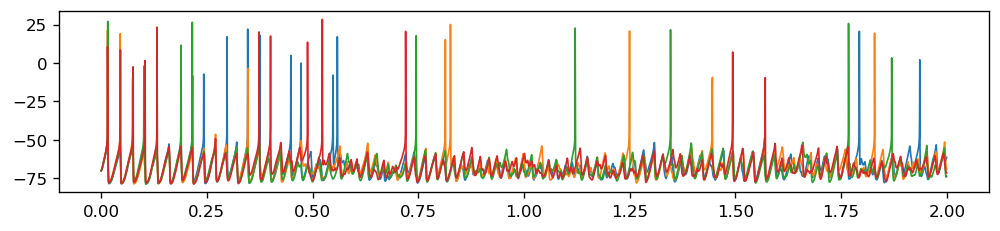

In [295]:
nid = 50

plt.figure(dpi=120, figsize=(10, 2))
plt.plot(obj.data["t"], obj.data["v"][:,[1,5,10,20]], lw=1)

plt.show()

1. case 7 is the almost synchronized regime


## PSD

In [296]:
def get_fft(x, fs, wbin=None, wbin_t=None):
    if wbin is None and wbin_t is None:
        N = len(x)
    elif wbin_t is not None:
        N = int(wbin_t*fs)
    elif wbin is not None:
        N = wbin

    yf = np.fft.fft(x, axis=0, n=N)
    yf = 2/N * np.abs(yf[:N//2])
    freq = np.linspace(0, 1/2*fs, N//2)
    return yf, freq


def get_stfft(x, t, fs, mbin_t=0.1, wbin_t=1, f_range=None, buf_size=100):

    wbin = int(wbin_t * fs)
    mbin = int(mbin_t * fs)
    window = np.hanning(wbin)
    
    ind = np.arange(wbin//2, len(t)-wbin//2, mbin, dtype=int)
    psd = np.zeros([wbin//2, len(ind)])
    
    n_id = 0
    while n_id < len(ind):
        n_buf = min([buf_size, len(ind)-n_id])
        y = np.zeros([wbin, n_buf])

        for i in range(n_buf):
            n = i + n_id
            n0 = max([0, ind[n]-wbin//2])
            n1 = min([ind[n]+wbin//2, len(t)])
            y[n0-(ind[n]-wbin//2):wbin-(ind[n]+wbin//2)+n1, i] = x[n0:n1]
        y = y * window[:,np.newaxis]
        yf, fpsd = get_fft(y, fs)
        psd[:, n_id:n_id+n_buf] = yf

        n_id += n_buf
    
    if f_range is not None:
        idf = (fpsd >= f_range[0]) & (fpsd <= f_range[1])
        psd = psd[idf, :]
        fpsd = fpsd[idf]
    tpsd = ind / fs
    
    return psd, fpsd, tpsd


def imshow_xy(im, x=None, y=None, cmap="jet", **kwargs):
    if x is None:
        x = np.arange(im.shape[1])
    if y is None:
        y = np.arange(im.shape[0])
    xy = (x[0], x[-1], y[0], y[-1])
    return plt.imshow(im, extent=xy, origin="lower", aspect="auto", cmap=cmap, **kwargs)


In [297]:
V = np.average(obj.data["v"], axis=1)
psd, fpsd, tpsd = get_stfft(V, obj.data["t"], 2000, mbin_t=0.01, wbin_t=0.3, f_range=[5, 300])

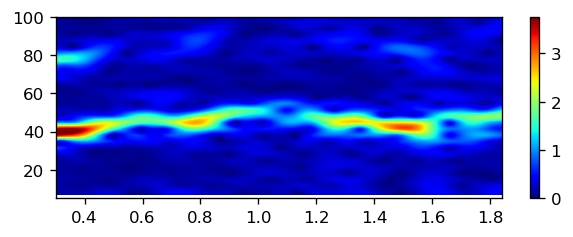

In [298]:
idt = tpsd >= 0.3

plt.figure(dpi=120, figsize=(6, 2))
imshow_xy(psd[:,idt], x=tpsd[idt], y=fpsd, interpolation='spline16', vmin=0, vmax=None)
plt.colorbar()
plt.ylim([5, 100])
plt.show()

In [273]:
def read_network(fname):
    with open(fname, "r") as fp:
        info = fp.readline().split(",")
        pre_range = [int(info[1]), int(info[2])]
        post_range = [int(info[4]), int(info[5])]
        
        adj_list = []
        l = fp.readline()
        while l:
            tmp = l.split(":")
            num_post = int(tmp[0])
            adj_list.append([int(x) for x in tmp[1].split(",")[:-1]])
            l = fp.readline()
    adj_list = adj_list[pre_range[0]:pre_range[1]]
    num_out = [len(adj) for adj in adj_list]
    return adj_list, num_out


def get_indeg(adj_list_out, nmax):
    indeg = np.array([0 for n in range(nmax)])
    for adj in adj_list_out:
        indeg[adj] += 1
    return indeg

In [274]:
adj_e, outdeg_e = read_network(os.path.join(obj.fdir, "./ntk_e.txt"))
adj_i, outdeg_i = read_network(os.path.join(obj.fdir, "./ntk_i.txt"))

def print_net_info(deg):
    print(f"avg: {np.average(deg)}, std: {np.var(deg)}")
print_net_info(outdeg_e)
print_net_info(outdeg_i)

avg: 150.0, std: 143.605
avg: 120.0, std: 103.35


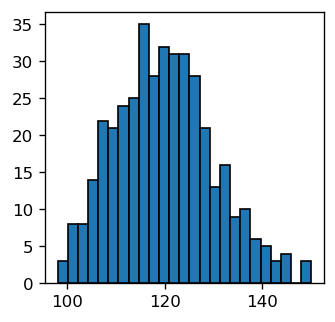

In [275]:
plt.figure(dpi=120, figsize=(3,3))
plt.hist(outdeg_i, 25, edgecolor='k')
plt.show()

## Test spike sync 

In [318]:
obj = DataLoder("./test")

chi,frs_m,frs_s,cv_isi
0.147729,71.296250,17.307184,0.364512,
0.244483,72.440000,20.246170,0.353136,
cij
989.121240,0.317255,
0.000000,60.770563,


chi,frs_m,frs_s,cv_isi
0.147729,71.296250,17.307184,0.364512,
0.244483,72.440000,20.246170,0.353136,
cij
0.163113,0.143278,
0.000000,0.224902,


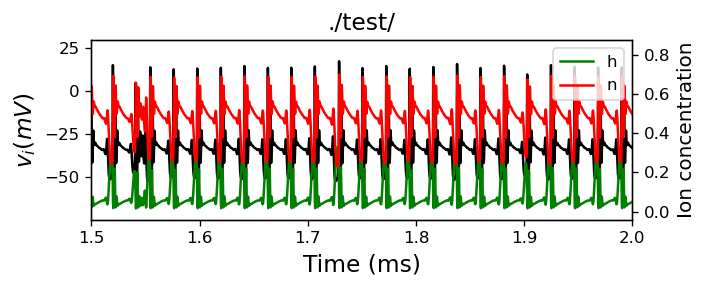

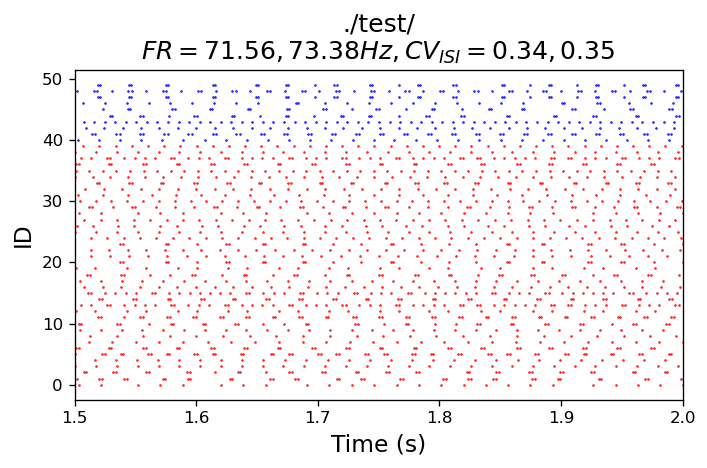

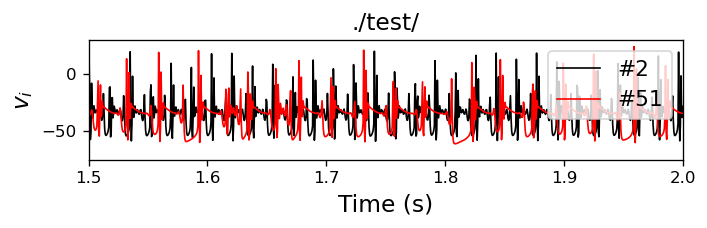

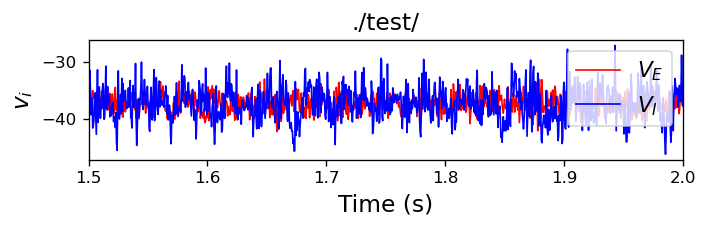

In [379]:
# obj = DataLoder("./case9_dec_e_dec_i///")
obj = DataLoder("./test/")
visu = DrawSummary(obj, [1.5, 2])

chi,frs_m,frs_s,cv_isi
0.131382,94.366250,33.394790,0.141350,
0.231980,104.390000,42.250478,0.042920,
cij
0.203811,0.191924,
0.000000,0.276840,


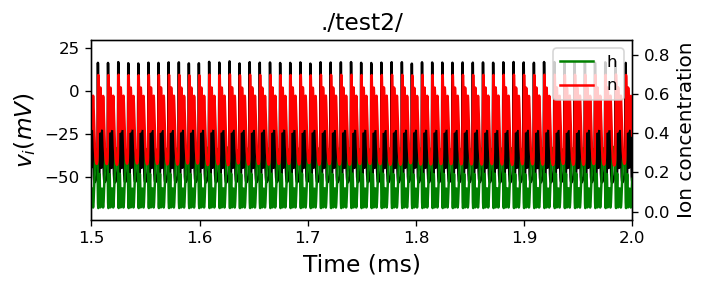

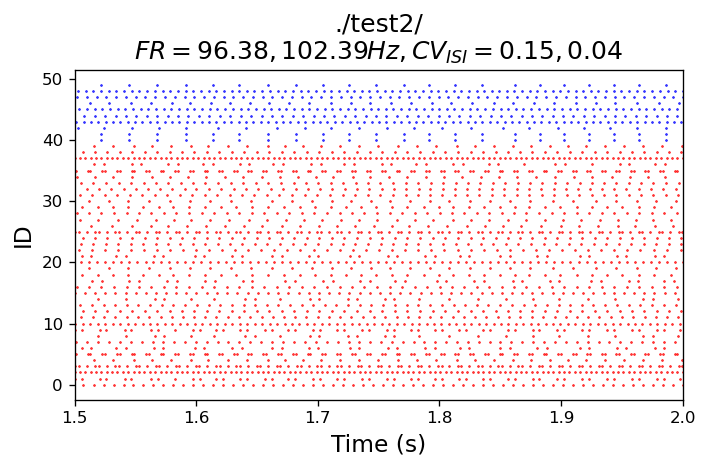

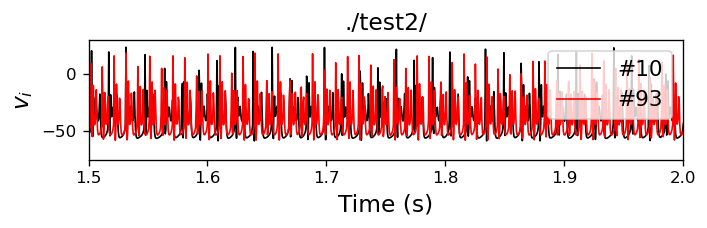

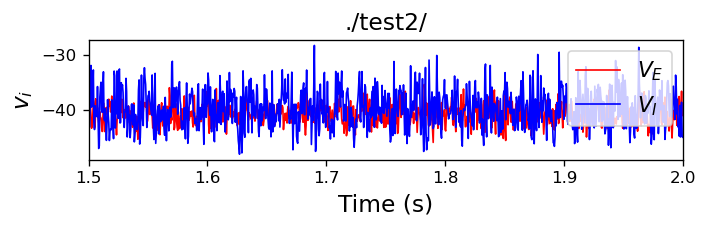

In [380]:
# obj = DataLoder("./case9_dec_e_dec_i///")
obj = DataLoder("./test2/")
visu = DrawSummary(obj, [1.5, 2])

In [374]:
# def get_correlogram(obj, tbin=5):
tbin = 5
l = int(obj.data["t"][-1]*1000/tbin) + 1
nbin = int(tbin/obj.dt)
n_vec = np.zeros([obj.N, l])
for n in range(obj.N):
    ids = (np.array(obj.step_spk[n])/nbin).astype('int')
    n_vec[n][ids] = 1
    
N = obj.N
corr_vec = np.zeros([N, N])
for i in range(N):
    for j in range(N):
        corr_vec[i, j] = np.dot(n_vec[i], n_vec[j]) / np.sqrt(np.sum(n_vec[i]) * np.sum(n_vec[j]))
        
ne = int(N * 0.8)        
cum = [[0, 0], [0, 0]]
sc = [[0, 0,], [0, 0]]
for i in range(N):
    id1 = i//ne
    for j in range(i, N):
        id2 = j//ne
        cum[id1][id2] += 1
        sc[id1][id2] += corr_vec[i, j]
        
for id1 in range(2):
    for id2 in range(2):
        if cum[id1][id2] == 0:
            continue
        sc[id1][id2] /= cum[id1][id2]

[[0.32997569 0.31725522]
 [0.         0.38462173]]


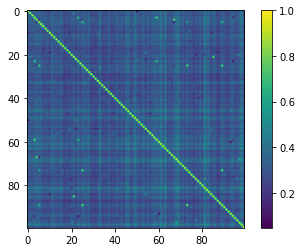

In [377]:
plt.imshow(corr_vec)
plt.colorbar()

print(np.array(sc))

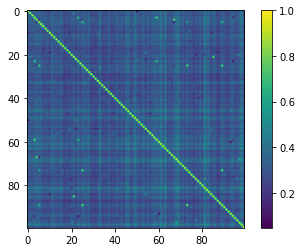

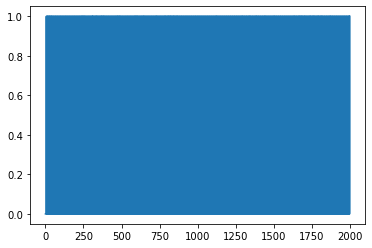

In [ ]:

plt.plot(n_vec[0])

100

In [ ]:
obj.step_spk[0][-1] // nbin

1999

In [ ]:
obj.step_spk[0][-1] * obj.dt / tbin

1999.9260000000002

In [ ]:
nbin

500

In [ ]:
get_correlogram(obj)

1999


IndexError: index 1002 is out of bounds for axis 0 with size 1000

In [ ]:
obj.step_spk[0]

### Check cluster ID

In [61]:
len(adj_e), len(adj_i)

(1600, 400)

In [ ]:
from collections import deque

def get_cluster_id(out_deg, pre_range, N):
    if 
    
    
    class_id = np.zeros(N)
    

## Single variable check

In [23]:
keys = ["v", "h", "i", "n"]
data_single = {}
for k in keys:
    with open(os.path.join(FDIR,"./single_%s.txt"%(k)), "r") as fid:
        data_single[k] = [float(x) for x in fid.readline().split(",")[:-1]]
        
dt = 0.01
t_single = np.arange(len(data_single["v"])) * dt

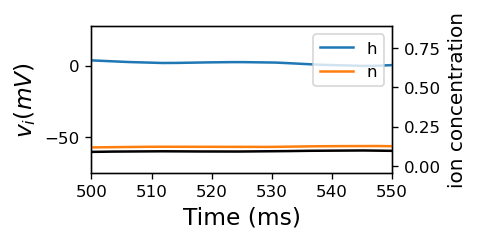

In [24]:
plt.figure(dpi=120, figsize=(4,2))
plt.plot(t_single, data_single["v"], c='k', label="v")
plt.xlabel("Time (ms)", fontsize=14)
plt.ylabel(r"$v_i (mV)$", fontsize=14)
plt.twinx()
plt.plot(t_single, data_single["h"], label="h")
plt.plot(t_single, data_single["n"], label="n")
plt.xlim([500, 550])
plt.legend(loc='upper right')
plt.ylabel("ion concentration", fontsize=12)

save_figure("single_var")
plt.show()

## Check output data

In [25]:
class SpikeVec:
    def __init__(self, tag):
        pass
    
    def read(self, tag):
        pass

with open(os.path.join(FDIR,"./spike_info.txt"), "r") as fid:
    num_spk = np.array([int(i) for i in fid.readline().split(",")[:-1]])
    
N = len(num_spk)
    
step_spk = []
with open(os.path.join(FDIR, "./spike.dat"), "rb") as fid:
    tmp = np.fromfile(fid, dtype=np.int32)
    n0 = 0
    for n in range(N):
        step_spk.append(tmp[n0:n0+num_spk[n]])
        n0 += num_spk[n]


# fs = 2000 ## -> 나중에 이것도 select 필요
fs = 10000
def read_data(fname, N=100):
    with open(os.path.join(FDIR,fname), "rb") as fp:
        data = np.fromfile(fp, dtype=np.float32).reshape([-1, N])
    t = np.arange(data.shape[0]) / fs
    return data, t

vs, t = read_data("./check_v.dat", N)
re, t = read_data("./check_syn_e.dat", N)
ri, t = read_data("./check_syn_i.dat", N)
rext, t = read_data("./check_syn_ext.dat", N)


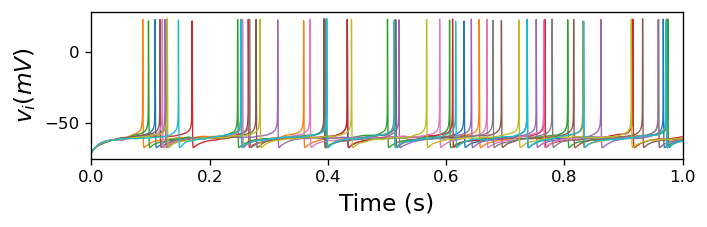

In [26]:
plt.figure(dpi=120, figsize=(6,2))
plt.plot(t, vs[:,:10], lw=0.8)
plt.xlim([0, 1])
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel(r"$v_i (mV)$", fontsize=14)
save_figure("vi")
plt.show()

In [22]:
def get_chi(vs):
    V = np.average(vs, axis=1)
    sV = np.var(V)
    svi = np.var(vs, axis=0)
    # print("var tot: %f, var indiv: %f"%(sV, svi * vs.shape[1]))
    # print(np.average(svi))
    return np.sqrt(sV / np.average(svi))


In [28]:
print(f'chi_e: {get_chi(vs[:,:4000]):.4f}, chi_i: {get_chi(vs[:,4000:]):.4f}')
import os
out = os.system('cat %s/result.txt'%(FDIR))

chi_e: 0.2166, chi_i: nan
chi,frs_m,frs_s
0.225065,6.675000,0.754569,
0.283350,6.450000,0.497494,


/Users/jungyoung/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/jungyoung/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/jungyoung/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


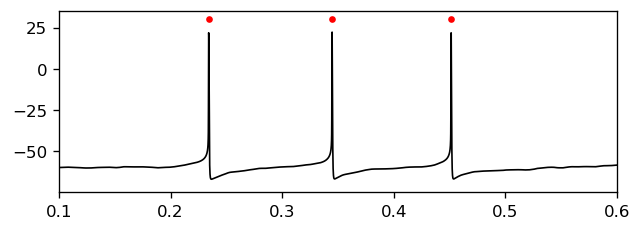

In [29]:
nid = 40
vth = 30
dt = 0.01

plt.figure(dpi=120, figsize=(6,2))
plt.plot(t, vs[:, nid], c='k', lw=1)
plt.plot(step_spk[nid]*dt/1000, [vth] * len(step_spk[nid]), 'r.')
plt.xlim([0.1, 0.6])
plt.show()

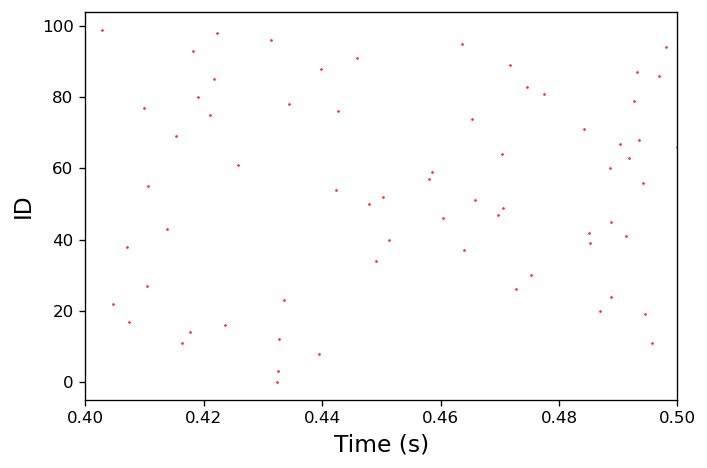

In [30]:
dt = 0.01

plt.figure(dpi=120, figsize=(6, 4))
for n, spk in enumerate(step_spk[:2000]):
    plt.plot(np.array(spk) * dt/1000, np.ones_like(spk) * n, 'r.', ms=1)
for n, spk in enumerate(step_spk[4000:]):
    plt.plot(np.array(spk) * dt/1000, np.ones_like(spk) * n+2000, 'b.', ms=1)
    
plt.xlim([0.4, 0.5])
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("ID", fontsize=14)
save_figure("raster_plot_sample")
plt.show()

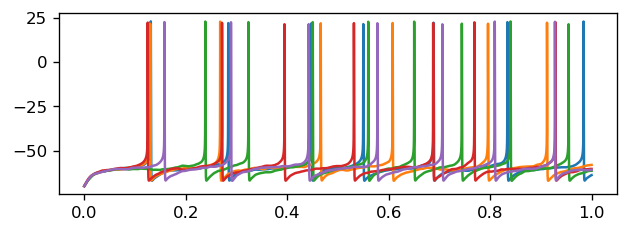

In [31]:
plt.figure(dpi=120, figsize=(6, 2))

ts = np.arange(vs.shape[0])/10000
plt.plot(ts, vs[:, 50:55])

plt.show()

## Power spectrogram density

## Auto correlation test

In [192]:
def get_corr(v, fs=2000):
    l = len(v)
    x = np.arange(-l, l-1) / fs
    y = v - np.average(v)
    c = np.correlate(y, y, mode='full')
    c = c / c[l]
    
    return c, x

ve = np.average(obj.data["v"][:,:1600], axis=1)
vi = np.average(obj.data["v"][:,1600:], axis=1)
# x = ve - np.average(ve)
# corr_e = np.correlate(x, x, mode='full')
corr_e, x = get_corr(ve)
corr_i, x = get_corr(vi)

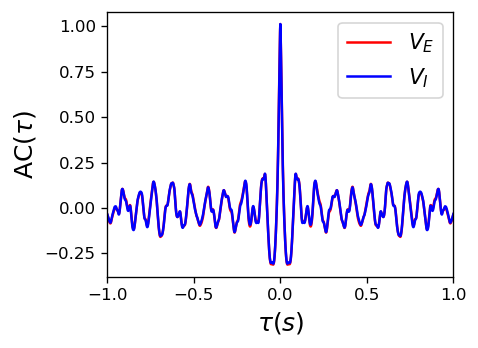

In [193]:
plt.figure(dpi=120, figsize=(4, 3))
plt.plot(x, corr_e, c='r', lw=1.5, label=r"$V_E$")
plt.plot(x, corr_i, c='b', lw=1.5, label=r"$V_I$")
plt.xlim([-1, 1])
plt.xlabel(r"$\tau (s)$", fontsize=15)
plt.ylabel(r"AC($\tau$)", fontsize=15)
plt.legend(loc="upper right", fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(obj.fdir, "fig_autocorrelation.png"), facecolor='w')
plt.show()